In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch

# importing the data
file_path = '/content/drive/MyDrive/train1.txt'
with open(file_path, 'r', encoding='utf-8') as file:
  captions = file.read()

print(f"{(len(captions)/1e6):.2f} million letters")

# total no of chars and vocab size
chars = sorted(list(set(captions)))
vocab_size = len(chars)
print(chars)
print(vocab_size)

485.52 million letters
['\n', 'A', 'C', 'G', 'T']
5


In [5]:
# map of characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(captions), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]
print(f"train data {(len(train_data)/1e6):.2f}million, val data {(len(val_data)/1e6):.2f}million")

train data 436.97million, val data 48.55million


In [8]:
import torch.nn as nn
from torch.nn import functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# hyperparams
batch_size = 10
block_size = 64
max_iters = 1000
eval_interval = 50
learning_rate = 3e-4
eval_iters = 10
d_model = 384
n_layer = 20
n_head = 20
dropout = 0.2
norm_eps = 1e-5

torch.manual_seed(1400)

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class SWiGLU(nn.Module):
  """ SWiGLU(x) = σ(x) ⊙ ReLU(x) + (1−σ(x)) ⊙ x """

  def forward(self, x):
    sigmoid_output = torch.sigmoid(x)
    relu_output = F.relu(x)
    out = sigmoid_output * relu_output + (1 - sigmoid_output) * x

    return out

class UnMaskedHead(nn.Module):
  """ single head of self attention """
  def __init__(self, d_model, head_size, dropout):
    super().__init__()
    self.key = nn.Linear(d_model, head_size, bias=True)
    self.query = nn.Linear(d_model, head_size, bias=True)
    self.value = nn.Linear(d_model, head_size, bias=True)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B, T, C = x.shape
    key = self.key(x)
    query = self.query(x)

    weights = query @ key.transpose(-2, -1) * key.shape[-1]**-0.5
    weights = F.softmax(weights, dim=-1)
    weights = self.dropout(weights)

    value = self.value(x)
    out = weights @ value
    return out

class MaskedHead(nn.Module):
  """ one head of self-attention """
  def __init__(self, head_size, dropout, d_model):
    super().__init__()
    self.key = nn.Linear(d_model, head_size, bias=True)
    self.query = nn.Linear(d_model, head_size, bias=True)
    self.value = nn.Linear(d_model, head_size, bias=True)
    self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    B,T,C = x.shape
    k = self.key(x)
    q = self.query(x)

    wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
    wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
    wei = F.softmax(wei, dim=-1) # (B, T, T)
    wei = self.dropout(wei)

    v = self.value(x)
    out = wei @ v
    return out

class MultiUnMasked(nn.Module):
  def __init__(self, d_model, n_head, dropout):
    head_size = d_model // n_head
    super().__init__()
    self.heads = nn.ModuleList([UnMaskedHead(d_model=d_model, dropout=dropout, head_size=head_size) for _ in range(n_head)])
    self.proj = nn.Linear(n_head * head_size, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

class MultiMasked(nn.Module):
  def __init__(self, d_model, n_head, dropout):
    head_size = d_model // n_head
    super().__init__()
    self.heads = nn.ModuleList([MaskedHead(d_model=d_model, dropout=dropout, head_size=head_size) for _ in range(n_head)])
    self.proj = nn.Linear(n_head * head_size, d_model)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(self.proj(out))
    return out

class FeedForward(nn.Module):
  def __init__(self, d_model, dropout):
    super().__init__()
    self.net = nn.Sequential(
      nn.Linear(d_model, 4*d_model),
      nn.GELU(),
      nn.Linear(4*d_model, d_model),
      nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.net(x)

class Block(nn.Module):
  def __init__(self, d_model, n_head, norm_eps, dropout):
    super().__init__()
    self.sa_masked = MultiMasked(n_head=n_head, d_model=d_model, dropout=dropout)
    self.sa_unmasked = MultiUnMasked(n_head=n_head, d_model=d_model, dropout=dropout)
    self.ffwd = FeedForward(d_model, dropout=dropout)
    self.norm1 = nn.LayerNorm(d_model, eps=norm_eps)
    self.norm2 = nn.LayerNorm(d_model, eps=norm_eps)

  def forward(self, x):
    x2 = x + self.sa_unmasked(self.norm1(x))
    x = x2 + self.ffwd(self.norm2(x2))

    x2 = x + self.sa_masked(self.norm1(x))
    x = x2 + self.ffwd(self.norm2(x2))
    return x

class Enigma(nn.Module):
  def __init__(self):
    super().__init__()
    self.toked_model = nn.Embedding(vocab_size, d_model)
    self.pos_encod = nn.Embedding(block_size, d_model)
    self.block = nn.Sequential(*[Block(d_model=d_model, dropout=dropout, norm_eps=norm_eps, n_head=n_head) for _ in range(n_layer)])
    self.norm_final = nn.LayerNorm(d_model, eps=norm_eps)
    self.linear_final = nn.Linear(d_model, vocab_size)
    self.apply(self._init_weights)


  def _init_weights(self, module):
    if isinstance(module, nn.Linear):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
      if module.bias is not None:
        torch.nn.init.zeros_(module.bias.data)
    elif isinstance(module, nn.Embedding):
      torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, idx, targets=None):
    B, T = idx.shape

    toked_model = self.toked_model(idx)
    pos_encod = self.pos_encod(torch.arange(T, device=device))
    x = toked_model + pos_encod
    x = self.block(x)
    x = self.norm_final(x)
    logits = self.linear_final(x)

    if targets is None:
      loss = None

    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)

    return logits, loss

  def complex_generate(self, idx, max_new_tokens, temperature=1.0, top_k=3, beam_width=5):
    beam = [(idx, 0)]  # start with the initial sequence and its log probability
    completed_beams = []

    for _ in range(max_new_tokens):
      new_beam = []

      for current_idx, log_prob in beam:
        idx_cond = current_idx[:, -block_size:]
        logits, _ = self(idx_cond)
        logits = logits[:, -1, :]  # (B, C)

        # temperature scaling
        scaled_logits = logits / temperature

        # top-k sampling
        if top_k > 0:
          scaled_logits = self._top_k_filtering(scaled_logits, top_k)

        # softmax
        probs = F.softmax(scaled_logits, dim=-1)  # (B, C)

        # sample from the distribution
        sampled_idx = torch.multinomial(probs, num_samples=beam_width)  # (B, beam_width)

        # expand the beam
        for i in range(beam_width):
          new_idx = torch.cat((current_idx, sampled_idx[:, i:i+1]), dim=1)
          new_log_prob = log_prob + torch.log(probs[:, sampled_idx[:, i]])
          new_beam.append((new_idx, new_log_prob.item()))

        # sort new beam by log probabilities
        new_beam = sorted(new_beam, key=lambda x: x[1], reverse=True)
        beam = new_beam[:beam_width] # only top beams

    completed_beams.append(beam)
    completed_beams = list(sorted(completed_beams, key=lambda x: x[1], reverse=True))

    return completed_beams

  def _top_k_filtering(self, logits, top_k):
    values, indices = torch.topk(logits, top_k, dim=-1)
    min_value = values[:, -1].unsqueeze(-1).expand_as(logits)
    filtered_logits = torch.where(logits < min_value, torch.ones_like(logits) * -float('inf'), logits)
    return filtered_logits

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
      # crop idx to the last block_size tokens
      idx_cond = idx[:, -block_size:]
      # get the predictions
      logits, loss = self(idx_cond)
      # focus only on the last time step
      logits = logits[:, -1, :] # becomes (B, C)
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B, C)
      # sample from the distribution
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append sampled index to the running sequence
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

model = Enigma()
m = model.to(device)

# no of parameters
n_param = sum(p.numel() for p in m.parameters())/1e6
print(f"{n_param:.2f} million")

# optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
steps = []
train_losses = []
val_losses = []

for iter in range(max_iters):

  if iter % eval_interval == 0 or iter == max_iters - 1:
    losses = estimate_loss()
    print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    steps.append(iter)
    train_losses.append(losses['train'])
    val_losses.append(losses['val'])

  xb, yb = get_batch('train')
  logits, loss = model(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()

47.10 million
step 0: train loss 1.7512, val loss 1.7694
step 100: train loss 1.3747, val loss 1.3551
step 200: train loss 1.3554, val loss 1.3393
step 300: train loss 1.3343, val loss 1.3292
step 400: train loss 1.3409, val loss 1.3244
step 500: train loss 1.0024, val loss 1.0057
step 600: train loss 0.0534, val loss 0.0528
step 700: train loss 0.0379, val loss 0.0378
step 800: train loss 0.0549, val loss 0.0487
step 900: train loss 0.0281, val loss 0.0263
step 999: train loss 0.0266, val loss 0.0256


In [9]:
torch.save(model.state_dict(), f'enigma_{n_param:.0f}m.pth')

In [10]:
target_text = "AGTTCTGCGAT"
context = torch.tensor([encode(target_text)], dtype=torch.long, device=device)
generated_output = decode(m.generate(context, max_new_tokens=10)[0].tolist())
print(generated_output)

AGTTCTGCGATGACAGTGCGC


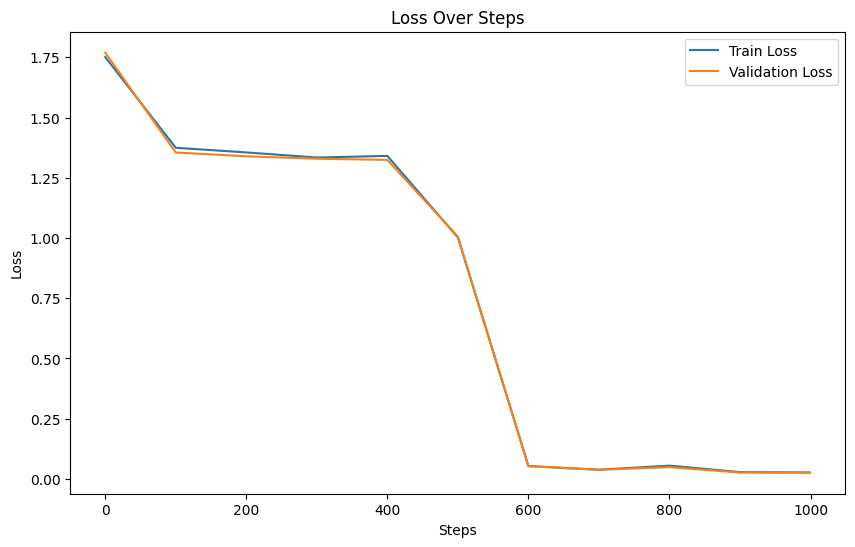

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Train Loss')
plt.plot(steps, val_losses, label='Validation Loss')
plt.title('Loss Over Steps')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.show()